In [1519]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import tzinfo, timedelta, datetime
import yfinance as yf
import random
import scipy.stats as stats

Set_start_date = '2024-06-01'


In [1520]:
#pull in data sources for trades and SP500 list
submission= pd.read_csv("/Users/maria/Documents/CodeOpDocs/Milestones/Indiv_Project/EDGAR_FILES/SUBMISSION.tsv", delimiter='\t')
non_deriv_trans= pd.read_csv("/Users/maria/Documents/CodeOpDocs/Milestones/Indiv_Project/EDGAR_FILES/NONDERIV_TRANS.tsv", delimiter='\t')
reporting_owner= pd.read_csv("/Users/maria/Documents/CodeOpDocs/Milestones/Indiv_Project/EDGAR_FILES/REPORTINGOWNER.tsv", delimiter='\t')

SNP= pd.read_csv("sp500_companies.csv")


C:\Users\maria\AppData\Local\Temp\ipykernel_27536\3541906008.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  non_deriv_trans= pd.read_csv("/Users/maria/Documents/CodeOpDocs/Milestones/Indiv_Project/EDGAR_FILES/NONDERIV_TRANS.tsv", delimiter='\t')


### make is so ACCESSION NUMBER is not Duplicated in Owner


In [1521]:
#make it so there is only ONE joined owner per ACCESSION_number
# I am putting all owners on one line, separted by commas

reporting_owner.groupby('ACCESSION_NUMBER').agg({'RPTOWNERNAME': ','.join})
owner_agg=reporting_owner.groupby('ACCESSION_NUMBER').agg({'RPTOWNERNAME': ','.join})


In [1522]:

owner_agg=owner_agg.reset_index()


In [1523]:
# This is an audit as checking the size of BAC sales
x =non_deriv_trans[non_deriv_trans['ACCESSION_NUMBER']=='0000950170-24-088078']
x['TRANS_PRICEPERSHARE']

39880    64.58
Name: TRANS_PRICEPERSHARE, dtype: float64


insider trade filing from EDGAR on https://www.sec.gov/data-research/sec-markets-data/insider-transactions-data-sets
SP500 stocks from Kaggle https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks/data

### Looking into the SP500 data to make sure enough large stocks are in my dataset

In [1524]:
#Exploring SP500 data
SNP['Symbol']
universe= submission['ISSUERTRADINGSYMBOL']

In [1525]:
#make list of stocks in my universe and in SP500
combined= []
for stock in universe:
    if stock in SNP['Symbol'].values:
        combined.append(stock)

print(combined)


['VLTO', 'HIG', 'MDT', 'NOW', 'L', 'MKC', 'DRI', 'DRI', 'DRI', 'PCAR', 'NOW', 'HIG', 'L', 'HIG', 'HBAN', 'AZO', 'DRI', 'RTX', 'ODFL', 'VLTO', 'AMP', 'DRI', 'CNP', 'HIG', 'HCA', 'DRI', 'HCA', 'CNP', 'LW', 'BMY', 'AZO', 'NOW', 'LW', 'PNR', 'HIG', 'L', 'AVY', 'MDT', 'PAYC', 'MDT', 'CRM', 'PAYC', 'HBAN', 'BX', 'HIG', 'LW', 'MKC', 'TEL', 'BMY', 'LW', 'MDT', 'DRI', 'LW', 'HIG', 'MDT', 'LW', 'DRI', 'MDT', 'WTW', 'FFIV', 'DRI', 'FFIV', 'TMO', 'DRI', 'MDT', 'MDT', 'NEM', 'AMGN', 'LW', 'HIG', 'DRI', 'NSC', 'NSC', 'NSC', 'NSC', 'AOS', 'TYL', 'PAYC', 'VTR', 'NVDA', 'RTX', 'RTX', 'HIG', 'NSC', 'NSC', 'NSC', 'NSC', 'CINF', 'DHI', 'ISRG', 'AOS', 'CINF', 'HLT', 'PGR', 'VZ', 'AEP', 'HLT', 'HLT', 'VZ', 'WMT', 'SYY', 'TROW', 'EXPE', 'TROW', 'TGT', 'ON', 'TROW', 'TER', 'A', 'VZ', 'TROW', 'ABBV', 'HRL', 'HUM', 'K', 'PAYC', 'HLT', 'PNC', 'KVUE', 'PANW', 'TROW', 'TROW', 'VZ', 'HLT', 'HLT', 'HLT', 'EA', 'DIS', 'VRSN', 'TER', 'HLT', 'WMT', 'VZ', 'LULU', 'TROW', 'VZ', 'DELL', 'DRI', 'GOOGL', 'MU', 'VZ', 'ADSK',

### Pulling out only the important information from each of the EDGAR files and doing a Merge

In [1526]:
# merge dataFrames
combo=submission.merge(non_deriv_trans,on='ACCESSION_NUMBER', how='inner')
combo=combo.merge(owner_agg,on='ACCESSION_NUMBER', how='inner')

In [1527]:
combo= combo.iloc[:][['ACCESSION_NUMBER','ISSUERTRADINGSYMBOL','TRANS_DATE','TRANS_FORM_TYPE',
                      'TRANS_CODE','TRANS_SHARES','TRANS_PRICEPERSHARE',
                      'ACCESSION_NUMBER','RPTOWNERNAME']]


In [1528]:
#This is an audit that the number of BAC shares really is that large
result=combo.groupby('ISSUERTRADINGSYMBOL')['TRANS_SHARES'].sum()
bac_count = result[result.index == 'BAC']
bac_count


ISSUERTRADINGSYMBOL
BAC    230850978.0
Name: TRANS_SHARES, dtype: float64

In [1529]:
#make a field to say whether data in SP500 in the submission data
combo['is_sp500']= combo['ISSUERTRADINGSYMBOL'].isin(combined)

#remove those not in SP500
combo=combo[combo['is_sp500']==True]



In [1530]:
#calculate how many data points are of each transaction type
combo['TRANS_CODE'].value_counts(True)

#remove those transactions which are not S or P

combo=combo[(combo['TRANS_CODE']=='P') | (combo['TRANS_CODE']=='S')]
combo.shape

(5669, 10)

In [1531]:
# Putting date to datetime format
combo['TRANS_DATE']=pd.to_datetime(combo['TRANS_DATE'],format="%d-%b-%Y")
combo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5669 entries, 0 to 55864
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ACCESSION_NUMBER     5669 non-null   object        
 1   ISSUERTRADINGSYMBOL  5669 non-null   object        
 2   TRANS_DATE           5669 non-null   datetime64[ns]
 3   TRANS_FORM_TYPE      5669 non-null   int64         
 4   TRANS_CODE           5669 non-null   object        
 5   TRANS_SHARES         5669 non-null   float64       
 6   TRANS_PRICEPERSHARE  5669 non-null   float64       
 7   ACCESSION_NUMBER     5669 non-null   object        
 8   RPTOWNERNAME         5669 non-null   object        
 9   is_sp500             5669 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 448.4+ KB


In [1532]:
#only focus on transactions where the transaction_form_type is 4 (which are regularly reported trades)

combo=combo[combo['TRANS_FORM_TYPE']==4]
combo.shape

(5668, 10)

In [1533]:
# Remove transactions where either the Transaction price is zero or NA
# Which was none after previous filtering

combo=combo[combo['TRANS_PRICEPERSHARE']!=0]
combo=combo.dropna(how='any',subset=['TRANS_PRICEPERSHARE'])
combo.shape

(5668, 10)

In [1534]:
# Remove transactions outside the study period, in this case outside Q3 2024 as assume those are late submissions

combo=combo[(combo['TRANS_DATE']>=Set_start_date)]
combo.shape

(5629, 10)

In [1535]:
# Calculating cost of transacted shares per line item (to be used later for getting avg cost of transacted stock)
combo['value_transacted']= combo['TRANS_SHARES'] * combo['TRANS_PRICEPERSHARE']


In [1536]:
# Due to the way i aggregated buyer and seller names, some of them mean the same thing but came up different. 
# I need to adjust the ones I'm using in graphs to make all Bershire/Buffett be the same

combo['RPTOWNERNAME']=combo['RPTOWNERNAME'].str.replace('BERKSHIRE HATHAWAY INC,BUFFETT WARREN E','BUFFETT WARREN E,BERKSHIRE HATHAWAY INC')
combo

,ACCESSION_NUMBER,ISSUERTRADINGSYMBOL,TRANS_DATE,TRANS_FORM_TYPE,TRANS_CODE,TRANS_SHARES,TRANS_PRICEPERSHARE,ACCESSION_NUMBER,RPTOWNERNAME,is_sp500,value_transacted
0,0001967680-24-000113,VLTO,2024-07-29,4,S,3000.0,105.89,0001967680-24-000113,Bystrom Mattias,True,317670.00
16,0001373715-24-000278,NOW,2024-07-30,4,S,3391.0,801.00,0001373715-24-000278,Chadwick Jonathan,True,2716191.00
25,0000060086-24-000156,L,2024-07-30,4,S,2628.0,80.88,0000060086-24-000156,SCHWARTZ MARK S,True,212552.64
47,0001225208-24-007749,PCAR,2024-07-31,4,S,27834.0,98.70,0001225208-24-007749,FEIGHT R PRESTON,True,2747215.80
57,0001373715-24-000280,NOW,2024-07-29,4,S,3286.0,808.27,0001373715-24-000280,MILLER JEFFREY A,True,2655975.22
...,...,...,...,...,...,...,...,...,...,...,...
55810,0001225208-24-007778,BSX,2024-08-01,4,S,6983.0,74.12,0001225208-24-007778,Carruthers Wendy,True,517579.96
55839,0001104659-24-084893,APH,2024-07-31,4,S,400000.0,64.28,0001104659-24-084893,NORWITT RICHARD ADAM,True,25712000.00
55843,0001127602-24-021416,JCI,2024-08-01,4,S,200.0,72.21,0001127602-24-021416,MANNING NATHAN D,True,14442.00
55844,0001127602-24-021416,JCI,2024-08-01,4,S,967.0,70.40,0001127602-24-021416,MANNING NATHAN D,True,68076.80


## Retrieving Stock and SP500 time series data

In [1537]:
#Here I am check the span of times that are part of my data
combo.iloc[:]['TRANS_DATE'].describe()

count                             5629
mean     2024-08-11 11:04:21.573991680
min                2024-06-27 00:00:00
25%                2024-07-25 00:00:00
50%                2024-08-12 00:00:00
75%                2024-08-30 00:00:00
max                2024-09-30 00:00:00
Name: TRANS_DATE, dtype: object

In [1538]:
#get the full list of stocks we need data for
#get rid of repeats using set and list
#I am also including S&P 500 ticker (ES=F) so we pull that data 
stock_selection=combo['ISSUERTRADINGSYMBOL']
stock_selection=set(stock_selection)
stock_selection=list(stock_selection) + ["ES=F"]


In [1539]:
#pull in stock data from what was Yahoo Finance
data = yf.download(stock_selection, period="1y")



[*********************100%***********************]  373 of 373 completed


In [1540]:
data.columns

MultiIndex([('Adj Close',    'A'),
            ('Adj Close', 'AAPL'),
            ('Adj Close', 'ABBV'),
            ('Adj Close', 'ABNB'),
            ('Adj Close',  'ABT'),
            ('Adj Close', 'ACGL'),
            ('Adj Close',  'ACN'),
            ('Adj Close', 'ADBE'),
            ('Adj Close',  'ADI'),
            ('Adj Close',  'ADM'),
            ...
            (   'Volume',  'WEC'),
            (   'Volume',   'WM'),
            (   'Volume',  'WMT'),
            (   'Volume',  'WST'),
            (   'Volume',   'WY'),
            (   'Volume', 'WYNN'),
            (   'Volume',  'XEL'),
            (   'Volume',  'XYL'),
            (   'Volume',  'YUM'),
            (   'Volume', 'ZBRA')],
           names=['Price', 'Ticker'], length=2238)

In [1541]:
#select only close prices
data=data['Close']

In [1542]:
#remove time-zone data from 'data' so it can be indexed

data=data.tz_convert(None)
data


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WEC,WM,WMT,WST,WY,WYNN,XEL,XYL,YUM,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2023-11-27,125.010002,189.789993,139.089996,129.000000,102.709999,87.000000,332.429993,619.270020,183.770004,73.190002,...,82.220001,171.479996,52.256668,353.899994,31.620001,87.059998,60.450001,103.180000,127.690002,231.500000
2023-11-28,124.709999,190.399994,138.080002,127.559998,102.059998,84.449997,332.559998,623.320007,183.199997,74.050003,...,83.160004,169.679993,52.880001,352.420013,31.540001,84.940002,60.970001,102.639999,126.389999,233.889999
2023-11-29,127.589996,189.369995,138.500000,126.480003,103.629997,82.379997,333.339996,617.390015,182.710007,73.190002,...,82.970001,169.740005,52.026669,348.920013,31.700001,83.669998,60.000000,103.500000,125.519997,236.619995
2023-11-30,127.800003,189.949997,142.389999,126.339996,104.290001,83.690002,333.140015,611.010010,183.380005,73.730003,...,83.620003,170.990005,51.896667,350.760010,31.350000,84.419998,60.840000,105.129997,125.550003,236.979996
2023-12-01,128.789993,191.240005,143.410004,135.020004,104.879997,82.629997,338.059998,612.469971,183.070007,75.080002,...,84.970001,173.800003,51.446667,351.790009,31.740000,85.150002,61.430000,106.199997,127.330002,241.220001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-20,128.570007,229.000000,167.759995,135.250000,115.930000,95.709999,357.070007,499.500000,211.009995,53.520000,...,99.269997,218.779999,87.180000,311.660004,30.670000,91.220001,70.050003,122.820000,132.880005,384.529999
2024-11-21,132.059998,228.520004,171.729996,133.259995,117.260002,98.589996,361.049988,504.440002,213.960007,53.189999,...,100.959999,221.529999,88.389999,320.880005,30.600000,91.739998,71.379997,125.360001,134.220001,392.309998
2024-11-22,133.839996,229.869995,176.949997,137.339996,117.760002,99.690002,358.660004,512.150024,214.589996,53.130001,...,100.660004,224.410004,90.440002,316.589996,31.240000,91.290001,71.349998,126.870003,135.270004,397.190002


In [1543]:
#pull out SP500 ticker out of data so it can be used alone for graphing reasons

SP_hist =data['ES=F']
SP_hist.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 253 entries, 2023-11-27 to 2024-11-26
Series name: ES=F
Non-Null Count  Dtype  
--------------  -----  
253 non-null    float64
dtypes: float64(1)
memory usage: 4.0 KB


## Shifting my stock prices so that I can see price development after the transaction

In [1544]:
#getting stock prices in the day before and the 5 days after
data_neg_1=data.shift(periods=1)
data_1=data.shift(periods=-1)
data_2=data.shift(periods=-2)
data_3=data.shift(periods=-3)
data_4=data.shift(periods=-4)
data_5=data.shift(periods=-5)

## Pulling out the data for use in Tableau

In [1545]:

combo.to_csv("/Users/maria/Desktop/csv_files/combo.csv",index=True, sep=',')
data.to_csv("/Users/maria/Desktop/csv_files/data.csv",index=True, sep=',')
SP_hist.to_csv("/Users/maria/Desktop/csv_files/SP_hist.csv",index=True, sep=',')

## Aggregating Transaction Data by buys and sells


In [1546]:
combo_sells =combo[combo['TRANS_CODE']=='S']
combo_buys =combo[combo['TRANS_CODE']=='P']

In [1547]:
#do the same using a pivot table so that i can pull out the sum TRANS_SHARE and avg TRANS_PRICEPERSHARE

piv_table_sells=pd.pivot_table(combo_sells,index=['TRANS_DATE','ISSUERTRADINGSYMBOL'],aggfunc={'TRANS_SHARES':np.sum,'value_transacted':np.sum})
piv_table_buys=pd.pivot_table(combo_buys,index=['TRANS_DATE','ISSUERTRADINGSYMBOL'],aggfunc={'TRANS_SHARES':np.sum,'value_transacted':np.sum})


C:\Users\maria\AppData\Local\Temp\ipykernel_27536\1742147295.py:3: FutureWarning: The provided callable <function sum at 0x00000219FE4434C0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  piv_table_sells=pd.pivot_table(combo_sells,index=['TRANS_DATE','ISSUERTRADINGSYMBOL'],aggfunc={'TRANS_SHARES':np.sum,'value_transacted':np.sum})
C:\Users\maria\AppData\Local\Temp\ipykernel_27536\1742147295.py:3: FutureWarning: The provided callable <function sum at 0x00000219FE4434C0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  piv_table_sells=pd.pivot_table(combo_sells,index=['TRANS_DATE','ISSUERTRADINGSYMBOL'],aggfunc={'TRANS_SHARES':np.sum,'value_transacted':np.sum})
C:\Users\maria\AppData\Local\Temp\ipykernel_27536\1742147295.py:4: FutureWarning: Th

In [1548]:
#add column in to tell direction of trade
piv_table_sells['direction']="S"
piv_table_buys['direction']="P"
piv_table_sells.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1731 entries, (Timestamp('2024-06-27 00:00:00'), 'ABNB') to (Timestamp('2024-09-30 00:00:00'), 'K')
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TRANS_SHARES      1731 non-null   float64
 1   value_transacted  1731 non-null   float64
 2   direction         1731 non-null   object 
dtypes: float64(2), object(1)
memory usage: 49.1+ KB


In [1549]:
#join the data again
piv_table=pd.concat([piv_table_sells,piv_table_buys], axis=0)

In [1550]:
#here i am pulling out the average price transacted in a day by insiders at that company
piv_table['transacted_avg']=piv_table['value_transacted']/piv_table['TRANS_SHARES']

In [1551]:
#I reset the index so that we can iterate through them for my calculations 
piv_table=piv_table.reset_index()

In [1552]:
#using iterrows we will now iterate through to calculate columns 
#with stock prices at time t-1, t0, t+1, t+2,t+3,t+4,t+5


#calc t-1 (day before the transaction)

for idx, row in piv_table.iterrows():
    trans_date=row['TRANS_DATE']
    symbol= row['ISSUERTRADINGSYMBOL']
    try:    
        value=data_neg_1.loc[trans_date,symbol]
        piv_table.loc[idx,"STOCK_-1"]=value
    except:
        piv_table.loc[idx,"STOCK_-1"]=np.nan

#calc t0 (day of the transaction)

for idx, row in piv_table.iterrows():
    trans_date=row['TRANS_DATE']
    symbol= row['ISSUERTRADINGSYMBOL']
    try:    
        value=data.loc[trans_date,symbol]
        piv_table.loc[idx,"STOCK_t0"]=value
    except:
        piv_table.loc[idx,"STOCK_t0"]=np.nan

#calc t+1 (day after  the transaction)
for idx, row in piv_table.iterrows():
    trans_date=row['TRANS_DATE']
    symbol= row['ISSUERTRADINGSYMBOL']
    try:    
        value=data_1.loc[trans_date,symbol]
        piv_table.loc[idx,"STOCK_t1"]=value
    except:
        piv_table.loc[idx,"STOCK_t1"]=np.nan

#calc t+2 (day 2 after  the transaction)        

for idx, row in piv_table.iterrows():
    trans_date=row['TRANS_DATE']
    symbol= row['ISSUERTRADINGSYMBOL']
    try:    
        value=data_2.loc[trans_date,symbol]
        piv_table.loc[idx,"STOCK_t2"]=value
    except:
        piv_table.loc[idx,"STOCK_t2"]=np.nan


#calc t+3 (day 3 after the transaction)   
for idx, row in piv_table.iterrows():
    trans_date=row['TRANS_DATE']
    symbol= row['ISSUERTRADINGSYMBOL']
    try:    
        value=data_3.loc[trans_date,symbol]
        piv_table.loc[idx,"STOCK_t3"]=value
    except:
        piv_table.loc[idx,"STOCK_t3"]=np.nan      


#calc t+4 (day 4 after the transaction)   
for idx, row in piv_table.iterrows():
    trans_date=row['TRANS_DATE']
    symbol= row['ISSUERTRADINGSYMBOL']
    try:    
        value=data_4.loc[trans_date,symbol]
        piv_table.loc[idx,"STOCK_t4"]=value
    except:
        piv_table.loc[idx,"STOCK_t4"]=np.nan    

#calc t+5 (day 5 after the transaction)   
for idx, row in piv_table.iterrows():
    trans_date=row['TRANS_DATE']
    symbol= row['ISSUERTRADINGSYMBOL']
    try:    
        value=data_5.loc[trans_date,symbol]
        piv_table.loc[idx,"STOCK_t5"]=value
    except:
        piv_table.loc[idx,"STOCK_t5"]=np.nan   

In [1553]:
#remove stocks where there is no data available 
piv_table=piv_table.dropna(how='any',subset=['STOCK_t0'])
piv_table

,TRANS_DATE,ISSUERTRADINGSYMBOL,TRANS_SHARES,value_transacted,direction,transacted_avg,STOCK_-1,STOCK_t0,STOCK_t1,STOCK_t2,STOCK_t3,STOCK_t4,STOCK_t5
0,2024-06-27,ABNB,11635.00,1.745483e+06,S,150.020000,150.000000,151.610001,151.630005,151.630005,154.339996,152.729996,152.500000
1,2024-06-27,ADSK,75.00,1.831650e+04,S,244.220000,243.279999,243.679993,247.449997,245.830002,247.860001,246.300003,247.869995
2,2024-06-27,AMZN,4710.00,9.184500e+05,S,195.000000,193.610001,197.850006,193.250000,197.199997,200.000000,197.589996,200.000000
3,2024-06-27,ANET,25000.00,8.675000e+06,S,347.000000,334.700012,347.929993,350.480011,356.700012,357.010010,365.420013,366.140015
4,2024-06-27,JNPR,40000.00,1.440000e+06,S,36.000000,35.689999,36.009998,36.459999,36.750000,36.570000,36.349998,36.720001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1783,2024-09-11,APTV,15295.00,9.815367e+05,P,64.173694,65.379997,65.470001,67.000000,68.949997,68.790001,70.220001,69.669998
1784,2024-09-11,BEN,100000.00,1.908000e+06,P,19.080000,19.500000,19.440001,19.670000,19.900000,20.110001,20.350000,20.389999
1785,2024-09-13,WY,7800.00,2.496780e+05,P,32.010000,31.410000,32.450001,32.509998,33.250000,33.099998,33.590000,33.240002
1786,2024-09-16,ED,0.93,9.771510e+01,P,105.070000,104.559998,104.849998,104.540001,103.410004,102.120003,103.349998,104.019997


## I need to remove "off market" transactions. I will define this as any transactions outside of the trading range of the 7 days I have


In [1554]:

#I will calculate the max and min

piv_table['max']= np.amax(piv_table[['STOCK_-1','STOCK_t0','STOCK_t1','STOCK_t2','STOCK_t3','STOCK_t4','STOCK_t5']], axis=1)

piv_table['min']= np.amin(piv_table[['STOCK_-1','STOCK_t0','STOCK_t1','STOCK_t2','STOCK_t3','STOCK_t4','STOCK_t5']], axis=1)

In [1555]:
#put in columns to filter if outside of the trading range
piv_table['is_above_min']=piv_table['transacted_avg']>piv_table['min']
piv_table['is_below_max']=piv_table['transacted_avg']<piv_table['max']

In [1556]:
#remove those outside the trading range
piv_table=piv_table[piv_table['is_above_min']==True]
piv_table=piv_table[piv_table['is_below_max']==True]


count    1451.000000
mean        1.000733
std         0.012154
min         0.922788
25%         0.995144
50%         1.000007
75%         1.004561
max         1.090044
Name: diff_to_executed, dtype: float64

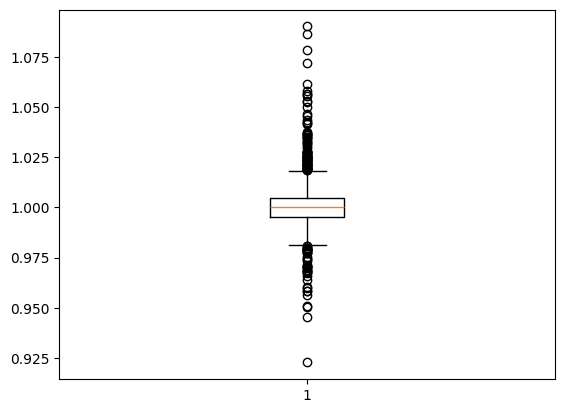

In [1557]:
#checking that the transacted prices are now in realm of where we expect them to be
piv_table['diff_to_executed']=piv_table['transacted_avg']/piv_table['STOCK_t0']
plt.boxplot(x=piv_table['diff_to_executed'])
piv_table['diff_to_executed'].describe()

## I will now create an index of the returns from random periods


In [1558]:
piv_table

,TRANS_DATE,ISSUERTRADINGSYMBOL,TRANS_SHARES,value_transacted,direction,transacted_avg,STOCK_-1,STOCK_t0,STOCK_t1,STOCK_t2,STOCK_t3,STOCK_t4,STOCK_t5,max,min,is_above_min,is_below_max,diff_to_executed
0,2024-06-27,ABNB,11635.00,1745482.70,S,150.020000,150.000000,151.610001,151.630005,151.630005,154.339996,152.729996,152.500000,154.339996,150.000000,True,True,0.989513
1,2024-06-27,ADSK,75.00,18316.50,S,244.220000,243.279999,243.679993,247.449997,245.830002,247.860001,246.300003,247.869995,247.869995,243.279999,True,True,1.002216
2,2024-06-27,AMZN,4710.00,918450.00,S,195.000000,193.610001,197.850006,193.250000,197.199997,200.000000,197.589996,200.000000,200.000000,193.250000,True,True,0.985595
3,2024-06-27,ANET,25000.00,8675000.00,S,347.000000,334.700012,347.929993,350.480011,356.700012,357.010010,365.420013,366.140015,366.140015,334.700012,True,True,0.997327
4,2024-06-27,JNPR,40000.00,1440000.00,S,36.000000,35.689999,36.009998,36.459999,36.750000,36.570000,36.349998,36.720001,36.750000,35.689999,True,True,0.999722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1780,2024-09-10,APTV,14475.00,967026.00,P,66.806632,69.080002,65.379997,65.470001,67.000000,68.949997,68.790001,70.220001,70.220001,65.379997,True,True,1.021821
1781,2024-09-10,DG,1000.00,80825.00,P,80.825000,80.980003,80.690002,80.570000,83.209999,84.750000,85.750000,86.010002,86.010002,80.570000,True,True,1.001673
1782,2024-09-10,HLT,4750.00,1001369.39,P,210.814608,214.940002,210.649994,211.580002,216.130005,216.820007,218.100006,220.380005,220.380005,210.649994,True,True,1.000781
1785,2024-09-13,WY,7800.00,249678.00,P,32.010000,31.410000,32.450001,32.509998,33.250000,33.099998,33.590000,33.240002,33.590000,31.410000,True,True,0.986441


In [1559]:
#make a copy of the dataframe
piv_table_control=piv_table.copy()

In [1560]:
# We will make a column called is_control so we can later concat the dataframes
piv_table['is_control']="False"
piv_table

,TRANS_DATE,ISSUERTRADINGSYMBOL,TRANS_SHARES,value_transacted,direction,transacted_avg,STOCK_-1,STOCK_t0,STOCK_t1,STOCK_t2,STOCK_t3,STOCK_t4,STOCK_t5,max,min,is_above_min,is_below_max,diff_to_executed,is_control
0,2024-06-27,ABNB,11635.00,1745482.70,S,150.020000,150.000000,151.610001,151.630005,151.630005,154.339996,152.729996,152.500000,154.339996,150.000000,True,True,0.989513,False
1,2024-06-27,ADSK,75.00,18316.50,S,244.220000,243.279999,243.679993,247.449997,245.830002,247.860001,246.300003,247.869995,247.869995,243.279999,True,True,1.002216,False
2,2024-06-27,AMZN,4710.00,918450.00,S,195.000000,193.610001,197.850006,193.250000,197.199997,200.000000,197.589996,200.000000,200.000000,193.250000,True,True,0.985595,False
3,2024-06-27,ANET,25000.00,8675000.00,S,347.000000,334.700012,347.929993,350.480011,356.700012,357.010010,365.420013,366.140015,366.140015,334.700012,True,True,0.997327,False
4,2024-06-27,JNPR,40000.00,1440000.00,S,36.000000,35.689999,36.009998,36.459999,36.750000,36.570000,36.349998,36.720001,36.750000,35.689999,True,True,0.999722,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1780,2024-09-10,APTV,14475.00,967026.00,P,66.806632,69.080002,65.379997,65.470001,67.000000,68.949997,68.790001,70.220001,70.220001,65.379997,True,True,1.021821,False
1781,2024-09-10,DG,1000.00,80825.00,P,80.825000,80.980003,80.690002,80.570000,83.209999,84.750000,85.750000,86.010002,86.010002,80.570000,True,True,1.001673,False
1782,2024-09-10,HLT,4750.00,1001369.39,P,210.814608,214.940002,210.649994,211.580002,216.130005,216.820007,218.100006,220.380005,220.380005,210.649994,True,True,1.000781,False
1785,2024-09-13,WY,7800.00,249678.00,P,32.010000,31.410000,32.450001,32.509998,33.250000,33.099998,33.590000,33.240002,33.590000,31.410000,True,True,0.986441,False


In [1561]:
#set up piv_table_control so we can fill it with data from same stocks on different days
piv_table_control['is_control']="True"
piv_table_control['transacted_avg']=np.nan
piv_table_control['value_transacted']=np.nan
piv_table_control['is_above_min']=np.nan
piv_table_control['is_below_max']=np.nan
piv_table_control['diff_to_executed']=np.nan

piv_table_control['STOCK_-1']=np.nan
piv_table_control['STOCK_t0']=np.nan
piv_table_control['STOCK_t1']=np.nan
piv_table_control['STOCK_t2']=np.nan
piv_table_control['STOCK_t3']=np.nan
piv_table_control['STOCK_t4']=np.nan
piv_table_control['STOCK_t5']=np.nan

piv_table

,TRANS_DATE,ISSUERTRADINGSYMBOL,TRANS_SHARES,value_transacted,direction,transacted_avg,STOCK_-1,STOCK_t0,STOCK_t1,STOCK_t2,STOCK_t3,STOCK_t4,STOCK_t5,max,min,is_above_min,is_below_max,diff_to_executed,is_control
0,2024-06-27,ABNB,11635.00,1745482.70,S,150.020000,150.000000,151.610001,151.630005,151.630005,154.339996,152.729996,152.500000,154.339996,150.000000,True,True,0.989513,False
1,2024-06-27,ADSK,75.00,18316.50,S,244.220000,243.279999,243.679993,247.449997,245.830002,247.860001,246.300003,247.869995,247.869995,243.279999,True,True,1.002216,False
2,2024-06-27,AMZN,4710.00,918450.00,S,195.000000,193.610001,197.850006,193.250000,197.199997,200.000000,197.589996,200.000000,200.000000,193.250000,True,True,0.985595,False
3,2024-06-27,ANET,25000.00,8675000.00,S,347.000000,334.700012,347.929993,350.480011,356.700012,357.010010,365.420013,366.140015,366.140015,334.700012,True,True,0.997327,False
4,2024-06-27,JNPR,40000.00,1440000.00,S,36.000000,35.689999,36.009998,36.459999,36.750000,36.570000,36.349998,36.720001,36.750000,35.689999,True,True,0.999722,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1780,2024-09-10,APTV,14475.00,967026.00,P,66.806632,69.080002,65.379997,65.470001,67.000000,68.949997,68.790001,70.220001,70.220001,65.379997,True,True,1.021821,False
1781,2024-09-10,DG,1000.00,80825.00,P,80.825000,80.980003,80.690002,80.570000,83.209999,84.750000,85.750000,86.010002,86.010002,80.570000,True,True,1.001673,False
1782,2024-09-10,HLT,4750.00,1001369.39,P,210.814608,214.940002,210.649994,211.580002,216.130005,216.820007,218.100006,220.380005,220.380005,210.649994,True,True,1.000781,False
1785,2024-09-13,WY,7800.00,249678.00,P,32.010000,31.410000,32.450001,32.509998,33.250000,33.099998,33.590000,33.240002,33.590000,31.410000,True,True,0.986441,False


In [1562]:
#Set range for the random trade dates (max is 2024-09-30, min is  2024-06-27)
piv_table_control['TRANS_DATE'].describe()
piv_table


,TRANS_DATE,ISSUERTRADINGSYMBOL,TRANS_SHARES,value_transacted,direction,transacted_avg,STOCK_-1,STOCK_t0,STOCK_t1,STOCK_t2,STOCK_t3,STOCK_t4,STOCK_t5,max,min,is_above_min,is_below_max,diff_to_executed,is_control
0,2024-06-27,ABNB,11635.00,1745482.70,S,150.020000,150.000000,151.610001,151.630005,151.630005,154.339996,152.729996,152.500000,154.339996,150.000000,True,True,0.989513,False
1,2024-06-27,ADSK,75.00,18316.50,S,244.220000,243.279999,243.679993,247.449997,245.830002,247.860001,246.300003,247.869995,247.869995,243.279999,True,True,1.002216,False
2,2024-06-27,AMZN,4710.00,918450.00,S,195.000000,193.610001,197.850006,193.250000,197.199997,200.000000,197.589996,200.000000,200.000000,193.250000,True,True,0.985595,False
3,2024-06-27,ANET,25000.00,8675000.00,S,347.000000,334.700012,347.929993,350.480011,356.700012,357.010010,365.420013,366.140015,366.140015,334.700012,True,True,0.997327,False
4,2024-06-27,JNPR,40000.00,1440000.00,S,36.000000,35.689999,36.009998,36.459999,36.750000,36.570000,36.349998,36.720001,36.750000,35.689999,True,True,0.999722,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1780,2024-09-10,APTV,14475.00,967026.00,P,66.806632,69.080002,65.379997,65.470001,67.000000,68.949997,68.790001,70.220001,70.220001,65.379997,True,True,1.021821,False
1781,2024-09-10,DG,1000.00,80825.00,P,80.825000,80.980003,80.690002,80.570000,83.209999,84.750000,85.750000,86.010002,86.010002,80.570000,True,True,1.001673,False
1782,2024-09-10,HLT,4750.00,1001369.39,P,210.814608,214.940002,210.649994,211.580002,216.130005,216.820007,218.100006,220.380005,220.380005,210.649994,True,True,1.000781,False
1785,2024-09-13,WY,7800.00,249678.00,P,32.010000,31.410000,32.450001,32.509998,33.250000,33.099998,33.590000,33.240002,33.590000,31.410000,True,True,0.986441,False


## Now we will work with the dataFrame 'data' to make a control set there as well 

In [1563]:
#We will now make a new index that we can later reference

data_control=data
ref=-1
for idx, row in data_control.iterrows():
    ref=ref+1  
    data_control.loc[idx,"ref_num"]=ref




In [1564]:
#we will pull out the dates as our index and replace them with our ref_num

data_control['Date']=data_control.index
data_control= data_control.set_index('ref_num')

In [1565]:
# we now know we need the ref numbers 150-216 (which is same as our iloc) these correspond to dates 2024-06-27 to 2024-09-30
data_control.iloc[150:216,:]

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WM,WMT,WST,WY,WYNN,XEL,XYL,YUM,ZBRA,Date
ref_num,,,,,,,,,,,,,,,,,,,,,
150.0,126.129997,221.550003,163.839996,152.729996,102.330002,97.650002,305.750000,570.150024,230.020004,62.689999,...,210.199997,68.239998,320.899994,27.049999,87.279999,52.750000,132.710007,129.580002,312.850006,2024-07-03
151.0,126.370003,226.339996,167.250000,152.500000,104.019997,98.150002,299.140015,578.340027,230.889999,61.360001,...,210.330002,70.040001,322.559998,27.450001,86.830002,52.689999,134.259995,129.119995,310.510010,2024-07-05
152.0,126.070000,227.820007,166.520004,151.960007,102.120003,98.260002,299.470001,575.400024,233.339996,63.380001,...,210.619995,69.680000,319.980011,27.590000,85.250000,52.110001,134.059998,127.940002,314.480011,2024-07-08
153.0,125.419998,228.679993,168.050003,152.449997,101.639999,98.000000,298.059998,566.020020,232.009995,63.130001,...,210.020004,69.900002,318.630005,27.570000,84.760002,52.470001,133.589996,126.660004,315.239990,2024-07-09
154.0,127.070000,232.979996,168.139999,151.839996,103.050003,97.500000,295.440002,564.549988,238.330002,64.230003,...,211.179993,70.410004,321.350006,27.580000,83.910004,52.590000,136.339996,129.169998,323.809998,2024-07-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211.0,148.479996,233.000000,197.479996,126.809998,114.010002,111.879997,353.480011,517.780029,230.169998,59.740002,...,207.600006,80.750000,300.160004,33.860001,95.879997,65.300003,135.029999,139.710007,370.320007,2024-09-30
212.0,146.559998,226.210007,196.960007,125.470001,113.559998,113.510002,351.980011,502.799988,223.669998,59.520000,...,207.929993,81.269997,299.799988,33.700001,99.449997,65.320000,134.389999,139.240005,364.299988,2024-10-01
213.0,146.539993,226.779999,196.820007,126.180000,113.639999,113.739998,356.290009,505.809998,227.729996,58.790001,...,207.320007,80.430000,299.809998,33.619999,102.040001,65.150002,134.380005,139.539993,368.679993,2024-10-02


In [1566]:
#we will now shift this data set so that we can pull t prices easily

data_neg_1_control=data_control.shift(periods=1)
data_1_control=data_control.shift(periods=-1)
data_2_control=data_control.shift(periods=-2)
data_3_control=data_control.shift(periods=-3)
data_4_control=data_control.shift(periods=-4)
data_5_control=data_control.shift(periods=-5)

In [1567]:
#we will now go back to pivot_table_control to give some random dates to our transactions
#we will now assign a random time variable within our reference range of dates from 150-216 correponding to ref and the period sampled.
random.seed(42)


for idx, row in piv_table_control.iterrows():
    a=random.randrange(start=150, stop=216, step=1)
    piv_table_control.loc[idx,'random_date_index']=int(a)


piv_table_control




,TRANS_DATE,ISSUERTRADINGSYMBOL,TRANS_SHARES,value_transacted,direction,transacted_avg,STOCK_-1,STOCK_t0,STOCK_t1,STOCK_t2,STOCK_t3,STOCK_t4,STOCK_t5,max,min,is_above_min,is_below_max,diff_to_executed,is_control,random_date_index
0,2024-06-27,ABNB,11635.00,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.339996,150.000000,NaN,NaN,NaN,True,164.0
1,2024-06-27,ADSK,75.00,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,247.869995,243.279999,NaN,NaN,NaN,True,153.0
2,2024-06-27,AMZN,4710.00,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200.000000,193.250000,NaN,NaN,NaN,True,185.0
3,2024-06-27,ANET,25000.00,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,366.140015,334.700012,NaN,NaN,NaN,True,181.0
4,2024-06-27,JNPR,40000.00,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.750000,35.689999,NaN,NaN,NaN,True,178.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1780,2024-09-10,APTV,14475.00,NaN,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.220001,65.379997,NaN,NaN,NaN,True,168.0
1781,2024-09-10,DG,1000.00,NaN,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.010002,80.570000,NaN,NaN,NaN,True,187.0
1782,2024-09-10,HLT,4750.00,NaN,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,220.380005,210.649994,NaN,NaN,NaN,True,204.0
1785,2024-09-13,WY,7800.00,NaN,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.590000,31.410000,NaN,NaN,NaN,True,150.0


In [1568]:
# I will now remove the dates
piv_table_control['TRANS_DATE']=np.nan

In [1569]:
#we will now use itterows to iterate throught to make our pivot table with our new values

#calc t-1 (day before the transaction)

for idx, row in  piv_table_control.iterrows():
    index_ref=int(row['random_date_index'])
    symbol= row['ISSUERTRADINGSYMBOL'] 
    try:
        value=data_neg_1_control.iloc[index_ref][symbol]
        piv_table_control.loc[idx,"STOCK_-1"]=value
    except:
        piv_table_control.loc[idx,"STOCK_-1"]=np.nan



#calc t0 (day of the transaction)
#here I am also calculating what the random date is via the index

for idx, row in  piv_table_control.iterrows():
    index_ref=int(row['random_date_index'])
    symbol= row['ISSUERTRADINGSYMBOL']
     
    value=data_control.iloc[index_ref][symbol]
    piv_table_control.loc[idx,"STOCK_t0"]=value

    date=data_control.iloc[index_ref]['Date']
    piv_table_control.loc[idx,'TRANS_DATE']=date


#calc t+1 (day after  the transaction)
for idx, row in  piv_table_control.iterrows():
    index_ref=int(row['random_date_index'])
    symbol= row['ISSUERTRADINGSYMBOL']
    try:    
        value=data_1_control.iloc[index_ref][symbol]
        piv_table_control.loc[idx,"STOCK_t1"]=value
    except:
        piv_table_control.loc[idx,"STOCK_t1"]=np.nan

#calc t+2 (day 2 after  the transaction)        

for idx, row in  piv_table_control.iterrows():
    index_ref=int(row['random_date_index'])
    symbol= row['ISSUERTRADINGSYMBOL']
    try:    
        value=data_2_control.iloc[index_ref][symbol]
        piv_table_control.loc[idx,"STOCK_t2"]=value
    except:
        piv_table_control.loc[idx,"STOCK_t2"]=np.nan


#calc t+3 (day 3 after the transaction)   
for idx, row in  piv_table_control.iterrows():
    index_ref=int(row['random_date_index'])
    symbol= row['ISSUERTRADINGSYMBOL']
    try:    
        value=data_3_control.iloc[index_ref][symbol]
        piv_table_control.loc[idx,"STOCK_t3"]=value
    except:
        piv_table_control.loc[idx,"STOCK_t3"]=np.nan      


#calc t+4 (day 4 after the transaction)   
for idx, row in  piv_table_control.iterrows():
    index_ref=int(row['random_date_index'])
    symbol= row['ISSUERTRADINGSYMBOL']
    try:    
        value=data_4_control.iloc[index_ref][symbol]
        piv_table_control.loc[idx,"STOCK_t4"]=value
    except:
        piv_table_control.loc[idx,"STOCK_t4"]=np.nan    

#calc t+5 (day 5 after the transaction)   
for idx, row in  piv_table_control.iterrows():
    index_ref=int(row['random_date_index'])
    symbol= row['ISSUERTRADINGSYMBOL']
    try:    
        value=data_5_control.iloc[index_ref][symbol]
        piv_table_control.loc[idx,"STOCK_t5"]=value
    except:
        piv_table_control.loc[idx,"STOCK_t5"]=np.nan   



C:\Users\maria\AppData\Local\Temp\ipykernel_27536\992004216.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2024-07-24 00:00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  piv_table_control.loc[idx,'TRANS_DATE']=date


In [1570]:
piv_table_control.head(3)

,TRANS_DATE,ISSUERTRADINGSYMBOL,TRANS_SHARES,value_transacted,direction,transacted_avg,STOCK_-1,STOCK_t0,STOCK_t1,STOCK_t2,STOCK_t3,STOCK_t4,STOCK_t5,max,min,is_above_min,is_below_max,diff_to_executed,is_control,random_date_index
0,2024-07-24 00:00:00,ABNB,11635.0,NaN,S,NaN,148.750000,144.229996,140.029999,140.100006,140.289993,138.990005,139.559998,154.339996,150.000000,NaN,NaN,NaN,True,164.0
1,2024-07-09 00:00:00,ADSK,75.0,NaN,S,NaN,247.960007,243.960007,247.050003,248.770004,253.449997,253.169998,253.820007,247.869995,243.279999,NaN,NaN,NaN,True,153.0
2,2024-08-22 00:00:00,AMZN,4710.0,NaN,S,NaN,180.110001,176.130005,177.039993,175.500000,173.119995,170.800003,172.119995,200.000000,193.250000,NaN,NaN,NaN,True,185.0


In [1571]:
#adding a random_date_index with nothing it it to piv_table in prep for concat
piv_table['random_date_index']=np.nan
piv_table.head(3)

,TRANS_DATE,ISSUERTRADINGSYMBOL,TRANS_SHARES,value_transacted,direction,transacted_avg,STOCK_-1,STOCK_t0,STOCK_t1,STOCK_t2,STOCK_t3,STOCK_t4,STOCK_t5,max,min,is_above_min,is_below_max,diff_to_executed,is_control,random_date_index
0,2024-06-27,ABNB,11635.0,1745482.7,S,150.02,150.000000,151.610001,151.630005,151.630005,154.339996,152.729996,152.500000,154.339996,150.000000,True,True,0.989513,False,NaN
1,2024-06-27,ADSK,75.0,18316.5,S,244.22,243.279999,243.679993,247.449997,245.830002,247.860001,246.300003,247.869995,247.869995,243.279999,True,True,1.002216,False,NaN
2,2024-06-27,AMZN,4710.0,918450.0,S,195.00,193.610001,197.850006,193.250000,197.199997,200.000000,197.589996,200.000000,200.000000,193.250000,True,True,0.985595,False,NaN


In [1572]:
#putting tables together
piv_combined=pd.concat([piv_table,piv_table_control],ignore_index=True)

#dropping unnecessary columns
piv_combined=piv_combined.drop(['is_above_min','is_below_max'], axis= 1)


In [1573]:
#make a copy of piv_combined where we can returns
piv_combined_normalized_prices=piv_combined.copy()

In [1574]:
#fixing name of columns
piv_combined=piv_combined.rename(columns={
                    'STOCK_-1':'Time_-1',
                    'STOCK_t0':'Time_0',
                    'STOCK_t1':'Time_1',
                    'STOCK_t2':'Time_2',
                    'STOCK_t3':'Time_3',
                    'STOCK_t4':'Time_4',
                    'STOCK_t5':'Time_5'})

In [1575]:
#calculating returns


piv_combined_normalized_prices['rTime_0']=(piv_combined_normalized_prices['STOCK_t0']-piv_combined_normalized_prices['STOCK_-1'])/piv_combined_normalized_prices['STOCK_-1']
piv_combined_normalized_prices['rTime_1']=(piv_combined_normalized_prices['STOCK_t1']-piv_combined_normalized_prices['STOCK_t0'])/piv_combined_normalized_prices['STOCK_t0']
piv_combined_normalized_prices['rTime_2']=(piv_combined_normalized_prices['STOCK_t2']-piv_combined_normalized_prices['STOCK_t1'])/piv_combined_normalized_prices['STOCK_t1']
piv_combined_normalized_prices['rTime_3']=(piv_combined_normalized_prices['STOCK_t3']-piv_combined_normalized_prices['STOCK_t2'])/piv_combined_normalized_prices['STOCK_t2']
piv_combined_normalized_prices['rTime_4']=(piv_combined_normalized_prices['STOCK_t4']-piv_combined_normalized_prices['STOCK_t3'])/piv_combined_normalized_prices['STOCK_t3']
piv_combined_normalized_prices['rTime_5']=(piv_combined_normalized_prices['STOCK_t5']-piv_combined_normalized_prices['STOCK_t4'])/piv_combined_normalized_prices['STOCK_t4']

piv_combined_normalized_prices.columns


Index(['TRANS_DATE', 'ISSUERTRADINGSYMBOL', 'TRANS_SHARES', 'value_transacted',
       'direction', 'transacted_avg', 'STOCK_-1', 'STOCK_t0', 'STOCK_t1',
       'STOCK_t2', 'STOCK_t3', 'STOCK_t4', 'STOCK_t5', 'max', 'min',
       'diff_to_executed', 'is_control', 'random_date_index', 'rTime_0',
       'rTime_1', 'rTime_2', 'rTime_3', 'rTime_4', 'rTime_5'],
      dtype='object')

In [1576]:
piv_combined_normalized_prices=piv_combined_normalized_prices.drop(columns={
     'value_transacted', 'transacted_avg', 'STOCK_-1', 'STOCK_t0', 'STOCK_t1',
       'STOCK_t2', 'STOCK_t3', 'STOCK_t4', 'STOCK_t5', 'max', 'min',
       'diff_to_executed', 'random_date_index'})



In [1577]:
piv_combined_normalized_prices.columns

Index(['TRANS_DATE', 'ISSUERTRADINGSYMBOL', 'TRANS_SHARES', 'direction',
       'is_control', 'rTime_0', 'rTime_1', 'rTime_2', 'rTime_3', 'rTime_4',
       'rTime_5'],
      dtype='object')

In [1578]:
#make this long form

stock_prices_returns= pd.melt(piv_combined_normalized_prices, id_vars=['TRANS_DATE', 'ISSUERTRADINGSYMBOL', 'TRANS_SHARES', 
       'direction', 'is_control',], value_vars=['rTime_0', 'rTime_1', 'rTime_2', 'rTime_3', 'rTime_4', 'rTime_5'])

stock_prices_returns

,TRANS_DATE,ISSUERTRADINGSYMBOL,TRANS_SHARES,direction,is_control,variable,value
0,2024-06-27,ABNB,11635.00,S,False,rTime_0,0.010733
1,2024-06-27,ADSK,75.00,S,False,rTime_0,0.001644
2,2024-06-27,AMZN,4710.00,S,False,rTime_0,0.021900
3,2024-06-27,ANET,25000.00,S,False,rTime_0,0.039528
4,2024-06-27,JNPR,40000.00,S,False,rTime_0,0.008966
...,...,...,...,...,...,...,...
17407,2024-07-30,APTV,14475.00,P,True,rTime_5,-0.001013
17408,2024-08-26,DG,1000.00,P,True,rTime_5,0.009883
17409,2024-09-19,HLT,4750.00,P,True,rTime_5,0.024275
17410,2024-07-03,WY,7800.00,P,True,rTime_5,0.050036


In [1579]:
#correct column names
stock_prices_returns=stock_prices_returns.rename(columns={'variable':'ref_time','value':'return'})

In [1580]:
#export CSV


## Making Stock_Prices into "long form" as recommended for use in Tableau

In [1581]:
stock_prices= pd.melt(piv_combined, id_vars=['TRANS_DATE', 'ISSUERTRADINGSYMBOL', 'TRANS_SHARES', 'value_transacted',
       'direction', 'transacted_avg', 'max', 'min',
       'diff_to_executed', 'is_control', 'random_date_index'], value_vars=['Time_-1', 'Time_0', 'Time_1', 'Time_2',
       'Time_3', 'Time_4', 'Time_5'])

In [1582]:
stock_prices=stock_prices.rename(columns={'variable':'ref_time','value':'price'})


In [1583]:
stock_prices=stock_prices.drop(columns={'value_transacted','diff_to_executed','random_date_index','transacted_avg'})
stock_prices

,TRANS_DATE,ISSUERTRADINGSYMBOL,TRANS_SHARES,direction,max,min,is_control,ref_time,price
0,2024-06-27,ABNB,11635.00,S,154.339996,150.000000,False,Time_-1,150.000000
1,2024-06-27,ADSK,75.00,S,247.869995,243.279999,False,Time_-1,243.279999
2,2024-06-27,AMZN,4710.00,S,200.000000,193.250000,False,Time_-1,193.610001
3,2024-06-27,ANET,25000.00,S,366.140015,334.700012,False,Time_-1,334.700012
4,2024-06-27,JNPR,40000.00,S,36.750000,35.689999,False,Time_-1,35.689999
...,...,...,...,...,...,...,...,...,...
20309,2024-07-30,APTV,14475.00,P,70.220001,65.379997,True,Time_5,69.050003
20310,2024-08-26,DG,1000.00,P,86.010002,80.570000,True,Time_5,83.790001
20311,2024-09-19,HLT,4750.00,P,220.380005,210.649994,True,Time_5,232.910004
20312,2024-07-03,WY,7800.00,P,33.590000,31.410000,True,Time_5,28.959999


In [1584]:
stock_prices_returns.to_csv("/Users/maria/Desktop/csv_files/stock_prices.csv",index=True, sep=',')

In [1585]:
#get series of Control Returns
stock_prices_returns
Control_returns=stock_prices_returns[(stock_prices_returns['is_control']=="True") & (stock_prices_returns['ref_time']=="rTime_2")]
Control_returns =Control_returns['return']
Control_returns

7255    0.000500
7256    0.006962
7257   -0.008699
7258    0.004914
7259    0.000516
          ...   
8701    0.053898
8702   -0.010230
8703    0.000089
8704    0.005100
8705   -0.000275
Name: return, Length: 1451, dtype: float64

In [1586]:
#get series of experiment returns

Experiment_returns=stock_prices_returns[(stock_prices_returns['is_control']=="False") & (stock_prices_returns['ref_time']=="rTime_2")]
Experiment_returns =Experiment_returns['return']
Experiment_returns

5804    0.000000
5805   -0.006547
5806    0.020440
5807    0.017747
5808    0.007954
          ...   
7250    0.023369
7251    0.032767
7252    0.021505
7253    0.022762
7254   -0.000778
Name: return, Length: 1451, dtype: float64

In [1587]:
#perform the Mann-Whitney U test
# I want to check if the experiment returns are 
# significantly less  than the control group so i will use "less"
stats.mannwhitneyu(Experiment_returns, Control_returns, alternative='less')

MannwhitneyuResult(statistic=np.float64(1023369.5), pvalue=np.float64(0.09686417989002788))

In [1588]:
#Permutation test to test difference in means 
# Group data
group_a = Experiment_returns
group_b = Control_returns

# 1. Calculate the observed test statistic (difference in means)
observed_diff = np.mean(group_a) - np.mean(group_b)

# 2. Combine the groups to create a pooled dataset
pooled_data = np.concatenate([group_a, group_b])

# 3. Set number of permutations (e.g., 10000)
n_permutations = 10000
permuted_diffs = []

# 4. Perform permutations
for _ in range(n_permutations):
    # Shuffle the pooled data and split it into two new groups
    np.random.shuffle(pooled_data)
    perm_group_a = pooled_data[:len(group_a)]
    perm_group_b = pooled_data[len(group_a):]
    
    # Calculate the difference in means for the permuted groups
    perm_diff = np.mean(perm_group_a) - np.mean(perm_group_b)
    permuted_diffs.append(perm_diff)

# 5. Calculate the p-value
# The p-value is the proportion of permuted differences that are as extreme as or more extreme than the observed difference
p_value = np.mean(np.abs(permuted_diffs) >= np.abs(observed_diff))

# Output the results
print(f"Observed difference in means: {observed_diff}")
print(f"P-value: {p_value}")

Observed difference in means: -0.0010296625942906776
P-value: 0.1337
